In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

#import dynesty

import sklearn
from sklearn import manifold
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

# Regression
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

## The HR diagram

This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by Deepraj Baidya and was originally published on Kaggle.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x249e8fe4e20>)

In [4]:
df_stars = pd.read_csv("stars.csv")
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


There are 6 star types that are encoded in the 'Star type' column. These labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type.

In [5]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


In [6]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,1,Blue,O
236,30839,834042.000000,1194.0000,-10.63,1,Blue,O
237,8829,537493.000000,1423.0000,-10.73,1,White,A
238,9235,404940.000000,1112.0000,-11.23,1,White,A


We've seen this already last time. It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:

- are there any missing values?
- are there NaNs in the data?

Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:

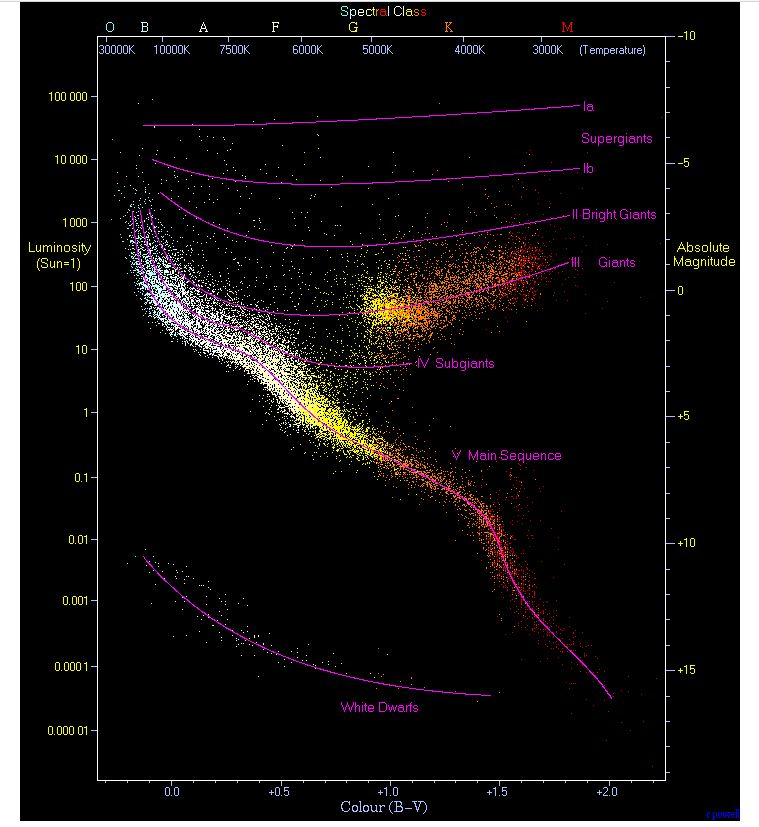

We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

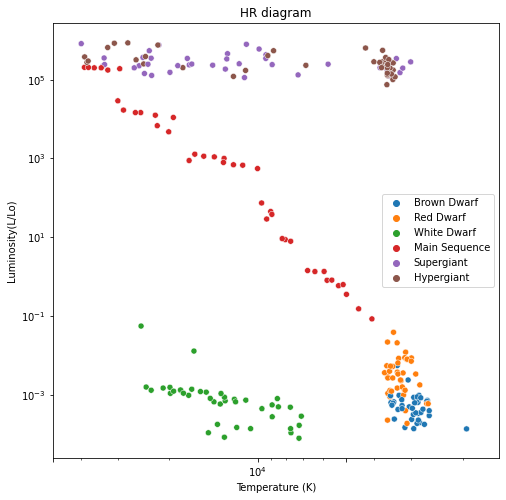

In [7]:
import seaborn as sns

fig = plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.title('HR diagram')
plt.show()

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

- Apply PCA to the dataset at your disposa (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two.
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

In [8]:
# define the vector for the analysis

X = np.array([df_stars['Temperature (K)'],df_stars['Luminosity(L/Lo)'],df_stars['Radius(R/Ro)'],
                  df_stars['Absolute magnitude(Mv)'],df_stars['Star type']]).T

X.shape

(240, 5)

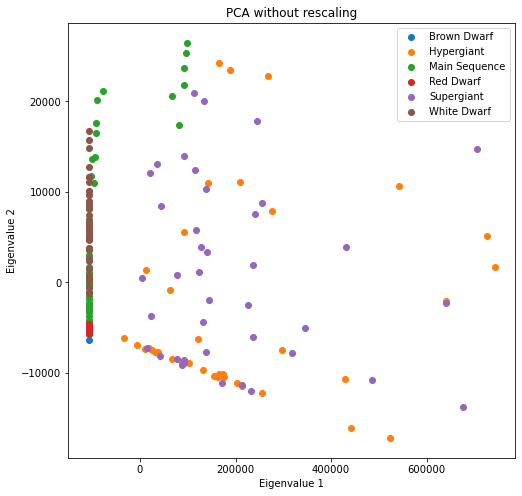

In [70]:
# apply PCA
pca = PCA(n_components=2)
pca.fit(X)
X_transformed = pca.transform(X)

fig = plt.figure(figsize=(8,8))

for st in class_names:
    mask_starType = X[:,-1]==le.transform([st]) # take only the data belonging to a given star_type
    plt.scatter(X_transformed[:,0][mask_starType], X_transformed[:,1][mask_starType],
                color='C%i'%le.transform([st])[0],label=st)

#plt.xscale('log')
#plt.yscale('log')
plt.title('PCA without rescaling')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
#plt.xlim(1e-6,1e6)
#plt.ylim(1e-5,1e5)

plt.legend()

This is actually a very important lesson in machine learning: Massaging your data before giving them to an algorithm can make things much much better.

- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is the usual machine-learning approach) standardize your data such that each dimension has mean=0 and variance=1.
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?

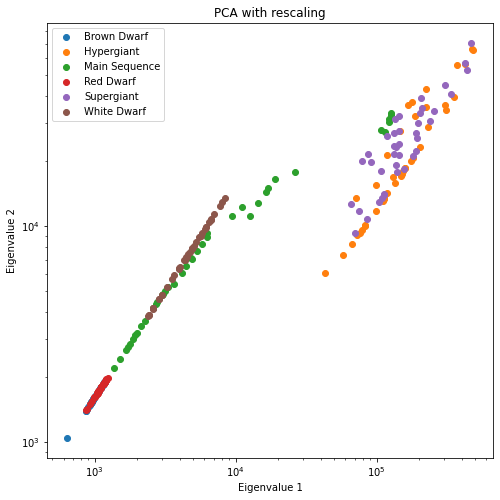

In [72]:
scaler = preprocessing.StandardScaler() # Standardize features by removing the mean and scaling to unit variance.

pca_rescale = PCA(n_components=2)
pca_rescale.fit(scaler.fit_transform(X))

X_transf_rescale = pca_rescale.transform(X)

fig = plt.figure(figsize=(8,8))

for st in class_names:
    mask_starType = X[:,-1]==le.transform([st]) # take only the data belonging to a given star_type
    plt.scatter(X_transf_rescale[:,0][mask_starType], X_transf_rescale[:,1][mask_starType],
                color='C%i'%le.transform([st])[0],label=st)
    
plt.xscale('log')
plt.yscale('log')

plt.title('PCA with rescaling')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
plt.legend()

In [38]:
evals = pca_rescale.explained_variance_ratio_
print('Explained variance ratio by 2 components:',np.sum(evals),'%')
print('Single components contribution:',evals,'%')

Explained variance ratio by 2 components: 0.7666873428856381 %
Single components contribution: [0.48394727 0.28274007] %


Let's try to add more components to pca (up to 4, since 5 doesn't make any sense)

Text(0.5, 1.0, 'Variance embedded in the cumulative PCA components')

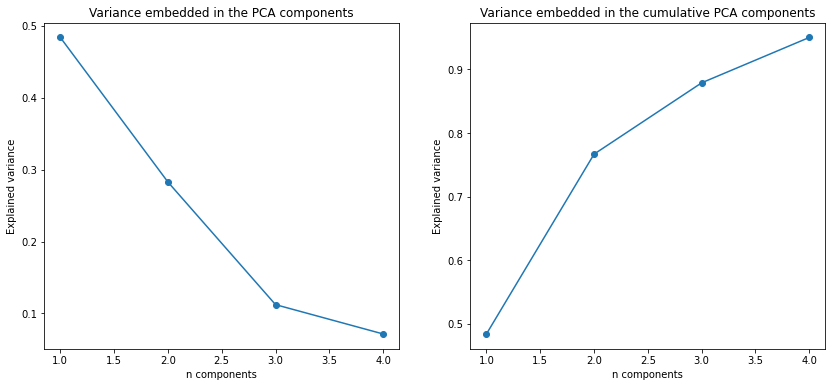

In [36]:
pca_var_study = PCA(n_components=4)
pca_var_study.fit(scaler.fit_transform(X))

evals_var_study = pca_var_study.explained_variance_ratio_

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,6))

ax[0].plot(np.arange(1,5),evals_var_study)
ax[0].scatter(np.arange(1,5),evals_var_study)
ax[0].set_xlabel('n components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Variance embedded in the PCA components')

ax[1].plot(np.arange(1,5),np.cumsum(evals_var_study))
ax[1].scatter(np.arange(1,5),np.cumsum(evals_var_study))
ax[1].set_xlabel('n components')
ax[1].set_ylabel('Explained variance')
ax[1].set_title('Variance embedded in the cumulative PCA components')